# PROJECT : A Hybrid Optimized VANET Routing Protocol Based on RNN and LPC for Reliable Communication

# Import libraries

In [111]:
# =======================
# 🌐 Standard Library
# =======================
import sys
import time
import warnings

# =======================
# 📦 Third-Party Libraries
# =======================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf

# =======================
# 🧠 Scikit-learn
# =======================
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split

# =======================
# 🔥 PyTorch
# =======================
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data import DataLoader, Subset, TensorDataset
from torch.utils.data import random_split, TensorDataset

# =======================
# 📊 Visualization (Jupyter)
# =======================
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

# =======================
# 🎨 Miscellaneous
# =======================
from colorama import Back, Fore, Style
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold # multi-label classification task
from sklearn.model_selection import StratifiedKFold  # single-label classification task
from numba import cuda

# =======================
# 🛠️ Debug Mode
# =======================
debug = True


# Check and use GPU if available

In [112]:
# Check if a CUDA GPU is available
# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "N/A")
print("Using device:", device)

GPU Name: NVIDIA GeForce RTX 4060 Laptop GPU
Using device: cuda


# Import and process the data

In [113]:
# Load data
file_path = "../dataset.txt"

with open(file_path, "r") as f:
    lines = f.readlines()

# Convert to a single 2D tensor
data = torch.tensor([[float(x) for x in line.strip().split(",")] for line in lines])


data = data.view(data.shape[0], 10)

print(data.shape)  # Check dimensions
# print(data)  # Print the tensor

print(data.shape)
# Define split sizes
train_dev_size = int(0.8 * len(data))
test_size = len(data) - train_dev_size

# Perform the split
train_dev_data, test_data = random_split(data, [train_dev_size, test_size])

# Convert to tensors
data = torch.tensor(data, dtype=torch.float32)
train_dev_data = torch.stack([data[i] for i in train_dev_data.indices])
test_data = torch.stack([data[i] for i in test_data.indices])

print(train_dev_data.shape)  # Should match (train_size, 10)
print(test_data.shape)   # Should match (dev_size, 10)

print(f"Train Dev Data Size: {len(train_dev_data)}")
print(f"Test Data Size: {len(test_data)}")


# Pad sequences to the same length
# data = pad_sequence(data, batch_first=True, padding_value=0.0)


torch.Size([10000, 10])
torch.Size([10000, 10])
torch.Size([8000, 10])
torch.Size([2000, 10])
Train Dev Data Size: 8000
Test Data Size: 2000


C:\Users\dodel\AppData\Local\Temp\ipykernel_10516\2918581267.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float32)


# Check data balance

Train Dev dataset : 
Count of numbers > 103 (Link Broken): 2739
Count of numbers <= 103 (Link Stable): 5261
Test dataset : 
Count of numbers > 103 (link broken): 669
Count of numbers <= 103 (link stable): 1331


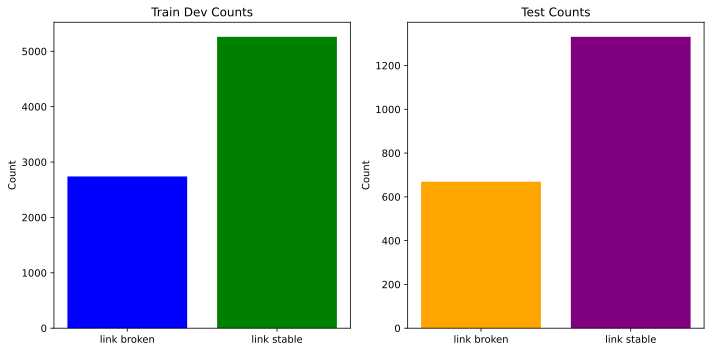

In [114]:
# It is important to check if all labels exist in test data
print("Train Dev dataset : ")
labels_train_dev, counts_train_dev = torch.unique(train_dev_data[:, -1], return_counts=True)
train_dev_count_gt = 0
train_dev_count_le = 0

for label, count in zip(labels_train_dev, counts_train_dev):
    # print(f"Label {label.item()} → {count.item()} samples")
    if label.item() > 103:
        train_dev_count_gt += count.item()
    else:
        train_dev_count_le += count.item()

print(f"Count of numbers > 103 (Link Broken): {train_dev_count_gt}")
print(f"Count of numbers <= 103 (Link Stable): {train_dev_count_le}")

print("Test dataset : ")
labels_test, counts_test = torch.unique(test_data[:, -1], return_counts=True)
test_count_gt = 0
test_count_le = 0

for label, count in zip(labels_test, counts_test):
    # print(f"Label {label.item()} → {count.item()} samples")
    if label.item() > 103:
        test_count_gt += count.item()
    else:
        test_count_le += count.item()

print(f"Count of numbers > 103 (link broken): {test_count_gt}")
print(f"Count of numbers <= 103 (link stable): {test_count_le}")

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# First pair (train_dev)
axs[0].bar(['link broken', 'link stable'], [train_dev_count_gt, train_dev_count_le], color=['blue', 'green'])
axs[0].set_title('Train Dev Counts')
axs[0].set_ylabel('Count')

# Second pair (test)
axs[1].bar(['link broken', 'link stable'], [test_count_gt, test_count_le], color=['orange', 'purple'])
axs[1].set_title('Test Counts')
axs[1].set_ylabel('Count')

# Display the plots
plt.tight_layout()
plt.show()

# Create a class for the DL model

In [115]:
def createModel(optimizer_name, learningRate, input_size, num_layers, hidden_size):

    class RNNNet(nn.Module):
        def __init__(self):
            super().__init__()

            self.dropout_prob = 0.3

            # RNN layer
            self.rnn = nn.RNN(
                input_size=input_size,   # Size of input features per time step
                hidden_size=hidden_size,  # Size of the hidden state
                num_layers=num_layers, # Number of RNN layers
                nonlinearity='tanh',  # or 'relu'
                bias=True,    # Include bias weights or not
                batch_first=True,  # True if input/output tensors are (batch, seq, feature)
                dropout=self.dropout_prob if num_layers > 1 else 0,  # Dropout between layers (if num_layers > 1)
                bidirectional=False  # True for bidirectional RNN not my case False
            )
                        
            self.bn = nn.BatchNorm1d(hidden_size)
            self.dropout = nn.Dropout(self.dropout_prob)
            self.fc = nn.Linear(hidden_size, 1)  # Regression output

        def forward(self, x, BN=False, dropout=False):
            rnn_out, _ = self.rnn(x)
            out = rnn_out[:, -1, :]  # Last time step

            if BN:
                out = self.bn(out)

            out = F.relu(out)

            if dropout:
                out = self.dropout(out)

            out = self.fc(out)  # No activation for regression
            return out

    # Create model
    model = RNNNet()

    # Regression loss function
    lossfun = nn.MSELoss()

    # Optimizer
    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=learningRate)

    return model, lossfun, optimizer


# Test if there is no error

In [116]:
# test the model with some data

optimizer_name = "SGD"
learning_rate = 0.01
seq_length = 9
batch_size = len(train_dev_data)

num_epochs = 50
input_size = 1 # "channels" of data
num_layers = 2 # depth of model (number of "stacks" of hidden layers)
hidden_size = 16 # breadth of model (number of units in hidden layers)
seq_length  = 9 # number of datapoints used for learning in each segment

# test the model with one batch
net,lossfun,optimizer = createModel(optimizer_name, learning_rate, input_size, num_layers, hidden_size)


X = (train_dev_data[:, :seq_length]).view(batch_size,seq_length,1)

print(X.shape)
y_pred = net(X)


print(y_pred.shape)

# print(y)
# grab the final predicted value from the output (first element of tuple output of net)
finalValue = y_pred[0][-1]
print(finalValue)

lossfun = nn.MSELoss()
lossfun(finalValue,train_dev_data[:, seq_length].view(batch_size,1))

torch.Size([8000, 9, 1])
torch.Size([8000, 1])
tensor(0.1614, grad_fn=<SelectBackward0>)


C:\Users\dodel\anaconda3\envs\notebook\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([8000, 1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(6489.8574, grad_fn=<MseLossBackward0>)

# Create a function that trains the model

In [117]:
from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score

debug = False

import sys

def custom_balanced_accuracy_score(pred_value, true_value, threshold=103):
    # Convert regression values to binary classes
    pred_classes = (pred_value > threshold).astype(int)
    true_classes = (true_value > threshold).astype(int)
    return balanced_accuracy_score(true_classes, pred_classes) * 100

def trainModel(net, lossfun, optimizer, num_epochs, train_data, dev_data, seq_length, num_layers, hidden_size):
    N_train = len(train_data[1])
    N_dev = len(dev_data[1])

    train_batch_size  = len(train_data[:, 0]) 
    dev_batch_size  = len(dev_data[:, 0]) 

    device = next(net.parameters()).device  # Use model's device

    # Track metrics
    losses = np.zeros(num_epochs)
    accuracyA = np.zeros(num_epochs)
    printed = False

    # Start measuring time
    start_time = time.time()

    # Initialize trackers
    trainLosses = torch.zeros(num_epochs)
    devLosses  = torch.zeros(num_epochs)
    trainAcc    = []
    devAcc     = []
    all_metrics = []  # To store (precision, recall, f1, balanced_acc) per fold FOR TRAIN
    dev_all_metrics = []  # To store (precision, recall, f1, balanced_acc) per fold FOR DEV
    
    for epoch in range(num_epochs):
        net.train()
        
        segment_losses = []
        segment_acc = []
        segment_all_metrics = []
        
        # Reset hidden state (for stateless RNNs)
        hidden_state = torch.zeros(num_layers, train_batch_size, hidden_size).to(device)

        # Iterate over the test sequence data to create sliding windows of length seq_length for input and predict the next value.
        for timei in range(N_train - seq_length):
            # Extract the training sequence
            X = train_data[:, timei:timei+seq_length].view(train_batch_size, seq_length, 1).to(device)
            # Extract the label or the last item of the sequence which indicates if link is broken or not
            y = train_data[:, timei + seq_length].view(train_batch_size, 1).to(device)

            # Forward pass
            y_pred = net(X)
            loss = lossfun(y_pred, y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Save the losses for each sequence of length : seq_length (In my case each line has only  one sequence of length seq_length + 1 )
            segment_losses.append(loss.item())
            true_value = y.cpu().numpy().squeeze()
            pred_value = y_pred.detach().cpu().numpy().squeeze()
         
            accuracy = custom_balanced_accuracy_score(pred_value, true_value)
            segment_acc.append(accuracy)


        # Save the losses and accuracy for for each epoch 
        trainLosses[epoch] = torch.tensor(segment_losses).mean()
        trainAcc.append(np.mean(segment_acc))

        # --- Evaluation on dev dataset ---
        net.eval()
        with torch.no_grad():
            segment_losses = []
            segment_acc = []
            segment_all_metrics = []

            for timei in range(N_dev - seq_length):
                X_dev = dev_data[:, timei:timei+seq_length].view(dev_batch_size, seq_length, 1).to(device)
                y_dev = dev_data[:, timei + seq_length].view(dev_batch_size, 1).to(device)

                y_dev_pred = net(X_dev)
                dev_loss = lossfun(y_dev_pred, y_dev)

                segment_losses.append(dev_loss.item())

            
                true_value = y_dev.cpu().numpy().squeeze()
                pred_value = y_dev_pred.detach().cpu().numpy().squeeze()

                accuracy = custom_balanced_accuracy_score(pred_value, true_value)
                segment_acc.append(accuracy)


            devLosses[epoch] = torch.tensor(segment_losses).mean()
            devAcc.append(np.mean(segment_acc))

            if debug:
                sys.stdout.write(
                    f'\rEpoch {epoch+1}/{num_epochs} - '
                    f'Train Loss: {trainLosses[epoch]:.4f} - '
                    f'Dev Loss: {devLosses[epoch]:.4f} - '
                    f'Balanced Train Acc: {trainAcc[epoch]:.2f}% - '
                    f'Balanced Dev Acc: {devAcc[epoch]:.2f}%'
                )
                sys.stdout.flush()

           

    # Total time
    total_time = time.time() - start_time
    if debug:
        print(f"\nTraining completed in {total_time:.2f} seconds")

    return net, trainAcc, devAcc, trainLosses, devLosses


# Train the model

In [118]:
def doIt():       
    k_folds = 5
    num_repeats = 3  # P times : K-Fold multiple times (P iterations) 
    
    # === STORAGE FOR METRICS
    final_train_acc = []
    final_dev_acc = []
    final_train_losses = []
    final_dev_losses = []
    
    mean_train_acc = []
    mean_dev_acc = []
    mean_train_losses = []
    mean_dev_losses = []
    
    # Convert to numpy
    X_np = train_dev_data.cpu().numpy() if isinstance(train_dev_data, torch.Tensor) else train_dev_data
    # Create labels based on the last column values (>103 or <=103)
    labels = np.where(X_np[:, -1] > 103, 1, 0)  # 1 if >103, otherwise 0
    

    for repeat in range(num_repeats):
        if debug:
            print(f"\n{Fore.RED}{Style.BRIGHT}=== Iteration {repeat+1}/{num_repeats} ==={Style.RESET_ALL}")
        
        all_fold_train_acc = []
        all_fold_dev_acc = []
        
        all_fold_train_losses = []
        all_fold_dev_losses = []
    
        skf = StratifiedKFold(n_splits=k_folds, shuffle=True) 
        
        for fold, (train_idx, dev_idx) in enumerate(skf.split(X_np, labels)):
            if debug:
                print(f"\n{Fore.GREEN}{Style.BRIGHT}=== Fold {fold+1}/{k_folds} ==={Style.RESET_ALL}")
        
            # Create train/dev datasets
            X_train, X_dev = train_dev_data[train_idx], train_dev_data[dev_idx]
  
            # === MODEL CREATION ===
            RNN, lossfun, optimizer = createModel(optimizer_name, learning_rate, input_size, num_layers, hidden_size)
            RNN.to(device)
        
            # Train
            net, trainAcc, devAcc, trainLosses, devLosses = trainModel(
                RNN, lossfun, 
                optimizer, 
                num_epochs, 
                X_train, 
                X_dev, 
                seq_length, 
                num_layers, 
                hidden_size
            )
    
            final_train_acc = trainAcc[-1]
            final_dev_acc = devAcc[-1]
        
            all_fold_train_losses.append(trainLosses)
            all_fold_dev_losses.append(devLosses)
            
            all_fold_train_acc.append(trainAcc)
            all_fold_dev_acc.append(devAcc)

            if debug:
                print(f"Fold {fold+1} Final Train Accuracy: {final_train_acc:.2f}%")
                print(f"Fold {fold+1} Final DEV Accuracy: {final_dev_acc:.2f}%")
    
        # calculate mean for this iteration
        mean_train_losses.append(np.mean(all_fold_train_losses, axis=0))
        mean_dev_losses.append(np.mean(all_fold_dev_losses, axis=0))
        
        mean_train_acc.append(np.mean(all_fold_train_acc, axis=0))
        mean_dev_acc.append(np.mean(all_fold_dev_acc, axis=0))

    
    return net, lossfun, mean_train_losses, mean_dev_losses, mean_train_acc, mean_dev_acc
    # incrementalTrainRNN(net, optimizer, data, newdata, seq_length, batch_size, num_layers, hidden_size)


net, lossfun, mean_train_losses, mean_dev_losses, mean_train_acc, mean_dev_acc = doIt()


# calculate mean for all iterations
final_train_losses = np.mean(mean_train_losses, axis=0)
final_dev_losses = np.mean(mean_dev_losses, axis=0)
final_train_acc = np.mean(mean_train_acc, axis=0)
final_dev_acc = np.mean(mean_dev_acc, axis=0)

print("################################################")
print(f"Final Train Losses: {final_train_losses[-1]:.2f}")
print(f"Final Dev Losses: {final_dev_losses[-1]:.2f}")
print(f"Final Balanced Train Accuracy: {final_train_acc[-1]:.2f}%")
print(f"Final Balanced Dev Accuracy: {final_dev_acc[-1]:.2f}%")


################################################
Final Train Losses: 1437.11
Final Dev Losses: 1435.07
Final Balanced Train Accuracy: 50.00%
Final Balanced Dev Accuracy: 50.00%


# Hyperparameter Tuning

In [119]:
# network parameters
optimizer_name = "Adam"
learning_rate = 0.01

use_batchnorm = True
use_dropout = True

num_epochs = 3000
input_size = 1 # "channels" of data
num_layers = 3 # depth of model (number of "stacks" of hidden layers)
hidden_size = 32 # breadth of model (number of units in hidden layers)
seq_length  = 9 # number of datapoints used for learning in each segment
# batch_size  = len(train_data[:, 0]) # Note: the training code is actually hard-coded to organize data into batch_size=1


# These for Hyperparameter Tuning
learning_rates = [0.001, 0.01, 0.1]
num_layers_list = [2, 3, 4]
dropout_rates = [False, True]

# These are the best selected Hyperparameter (after exprementation)
learning_rates = [0.01]
num_layers_list = [3]
dropout_rates = [True]

num = 0
for dropout in dropout_rates:
    use_dropout = dropout
    for lr in learning_rates:
        learning_rate = lr
        for num_l in num_layers_list:
            num_layers = num_l
            num +=1
            print(f"#{num}   ################################################")
            print(f"Learning Rate: {lr}, Number of Layers: {num_l}, Dropout Rate: {dropout}")
            # Here you can call your training function with these parameters
            net, lossfun, mean_train_losses, mean_dev_losses, mean_train_acc, mean_dev_acc = doIt()
            # calculate mean for all iterations
            final_train_losses = np.mean(mean_train_losses, axis=0)
            final_dev_losses = np.mean(mean_dev_losses, axis=0)
            final_train_acc = np.mean(mean_train_acc, axis=0)
            final_dev_acc = np.mean(mean_dev_acc, axis=0)
            
            print(f"Final Balanced Dev Accuracy: {final_dev_acc[-1]:.2f}%")
            print("################################################")



#1   ################################################
Learning Rate: 0.01, Number of Layers: 3, Dropout Rate: True
Final Balanced Dev Accuracy: 95.74%
################################################


# Plots

Train accuracy : 95.95%
Dev accuracy : 95.74%


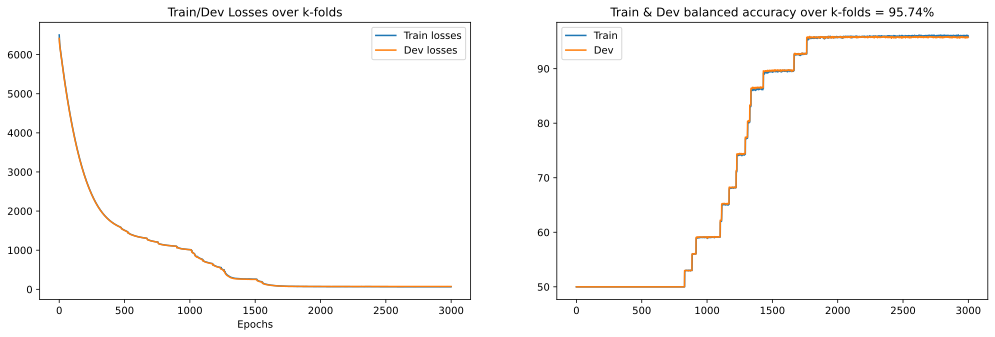

In [120]:
print(f"Train accuracy : {final_train_acc[-1]:.2f}%")
print(f"Dev accuracy : {final_dev_acc[-1]:.2f}%")


net.eval()


# plot the results
fig,axs = plt.subplots(1, 2,figsize=(17,5))

axs[0].plot(final_train_losses, label='Train losses')
axs[0].plot(final_dev_losses, label='Dev losses')
axs[0].set_title('Train/Dev Losses over k-folds')
axs[0].set_xlabel('Epochs')
axs[0].legend()

axs[1].plot(final_train_acc,label='Train')
axs[1].legend()
# plt.xlim(0, 5)
axs[1].plot(final_dev_acc,label='Dev')
axs[1].set_title(f'Train & Dev balanced accuracy over k-folds = {final_dev_acc[-1]:.2f}%')
axs[0].set_xlabel('Epochs')

axs[1].legend()

plt.show()


# Test on test dataset

In [121]:
# --- Evaluation on test dataset ---
N_test = len(test_data[1])
test_batch_size  = len(test_data[:, 0])


seq_length  = 9
net.eval()
with torch.no_grad():
    segment_losses = []
    segment_acc = []
    
    for timei in range(N_test - seq_length):
        X_test = test_data[:, timei:timei+seq_length].view(test_batch_size, seq_length, 1).to(device)
        y_test = test_data[:, timei + seq_length].view(test_batch_size, 1).to(device)

        y_test_pred = net(X_test)
        test_loss = lossfun(y_test_pred, y_test)

        segment_losses.append(test_loss.item())

        true_value = y_test.cpu().numpy().squeeze()
        pred_value = y_test_pred.detach().cpu().numpy().squeeze()
        
        acc = custom_balanced_accuracy_score(pred_value, true_value)
        segment_acc.append(acc)

    losses = torch.tensor(segment_losses).mean()
    accuracy = np.mean(segment_acc)


sys.stdout.write(f'\r Test Loss: {losses:.4f} - Test Acc: {accuracy:.2f}%')
sys.stdout.flush()

 Test Loss: 52.6374 - Test Acc: 96.59%